# Final CNN Model

## Import Necessary Libraries

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


## Import Data

In [2]:
#define data paths
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

## Create data generators with augmentation

In [3]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [4]:
#test the generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 544 images belonging to 3 classes.
Found 154 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


## Final Model

In [9]:
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = create_model()

In [10]:


#set up early stopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 790ms/step - accuracy: 0.4688 - loss: 1.3435 - val_accuracy: 0.5649 - val_loss: 1.0067
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 873ms/step - accuracy: 0.5202 - loss: 1.0648 - val_accuracy: 0.5649 - val_loss: 0.9738
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 784ms/step - accuracy: 0.5294 - loss: 1.0377 - val_accuracy: 0.5649 - val_loss: 0.9693
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 801ms/step - accuracy: 0.5460 - loss: 1.0250 - val_accuracy: 0.5649 - val_loss: 0.9587
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 799ms/step - accuracy: 0.5607 - loss: 0.9897 - val_accuracy: 0.5649 - val_loss: 0.9538
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/step - accuracy: 0.5570 - loss: 1.0031 - val_accuracy: 0.5649 - val_loss: 0.9696
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 725ms/step - accuracy: 0.5570 - loss: 0.9803 - val_accuracy: 0.5779 - val_loss: 0.9482
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 797ms/step - accuracy: 0.5790 - loss: 0.9462 - val_accu

In [11]:
#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.7927 - loss: 0.5209
Loss = 0.5208817720413208
Test Accuracy = 0.792682945728302


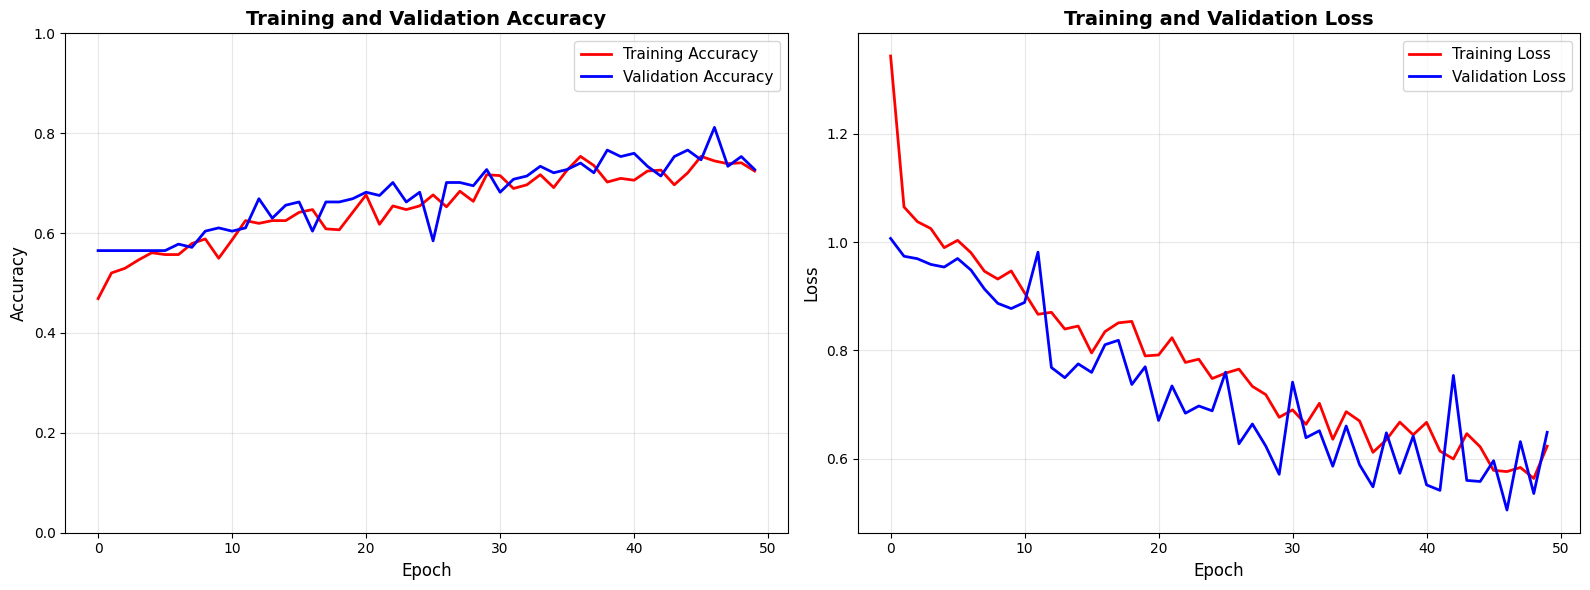


  Training Summary
  Best Training Accuracy:   0.7537 (epoch 37)
  Best Validation Accuracy: 0.8117 (epoch 47)
  Final Training Accuracy:  0.7243
  Final Validation Accuracy:0.7273
  Accuracy Gap (final):     0.0030


In [12]:
#training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs actually executed with early stopping
epochs_range = range(len(acc))

#create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

#plot loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print summary stats
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

In [13]:
#evaluate on validation set
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Validation Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step
Validation Classification Report:
              precision    recall  f1-score   support

      benign       0.56      0.55      0.56        87
   malignant       0.19      0.17      0.18        41
      normal       0.21      0.27      0.24        26

    accuracy                           0.40       154
   macro avg       0.32      0.33      0.33       154
weighted avg       0.41      0.40      0.40       154



In [14]:
#evaluate on train set
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Train Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 640ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.57      0.54      0.56       305
   malignant       0.30      0.33      0.32       147
      normal       0.18      0.17      0.18        92

    accuracy                           0.42       544
   macro avg       0.35      0.35      0.35       544
weighted avg       0.43      0.42      0.43       544



In [15]:
#evaluate on test set
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.60      0.60      0.60        45
   malignant       0.17      0.14      0.15        22
      normal       0.26      0.33      0.29        15

    accuracy                           0.43        82
   macro avg       0.34      0.36      0.35        82
weighted avg       0.42      0.43      0.42        82



### Display sample predictions

In [ ]:

# get file paths for test images
from pathlib import Path

# collect all test image paths organized by  true class
test_image_paths = {}
test_dir = Path(TEST_DIR)

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        test_image_paths[class_name] = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))

print(f"Found classes in test set: {list(test_image_paths.keys())}")


Found classes in test set: ['malignant', 'benign', 'normal']


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


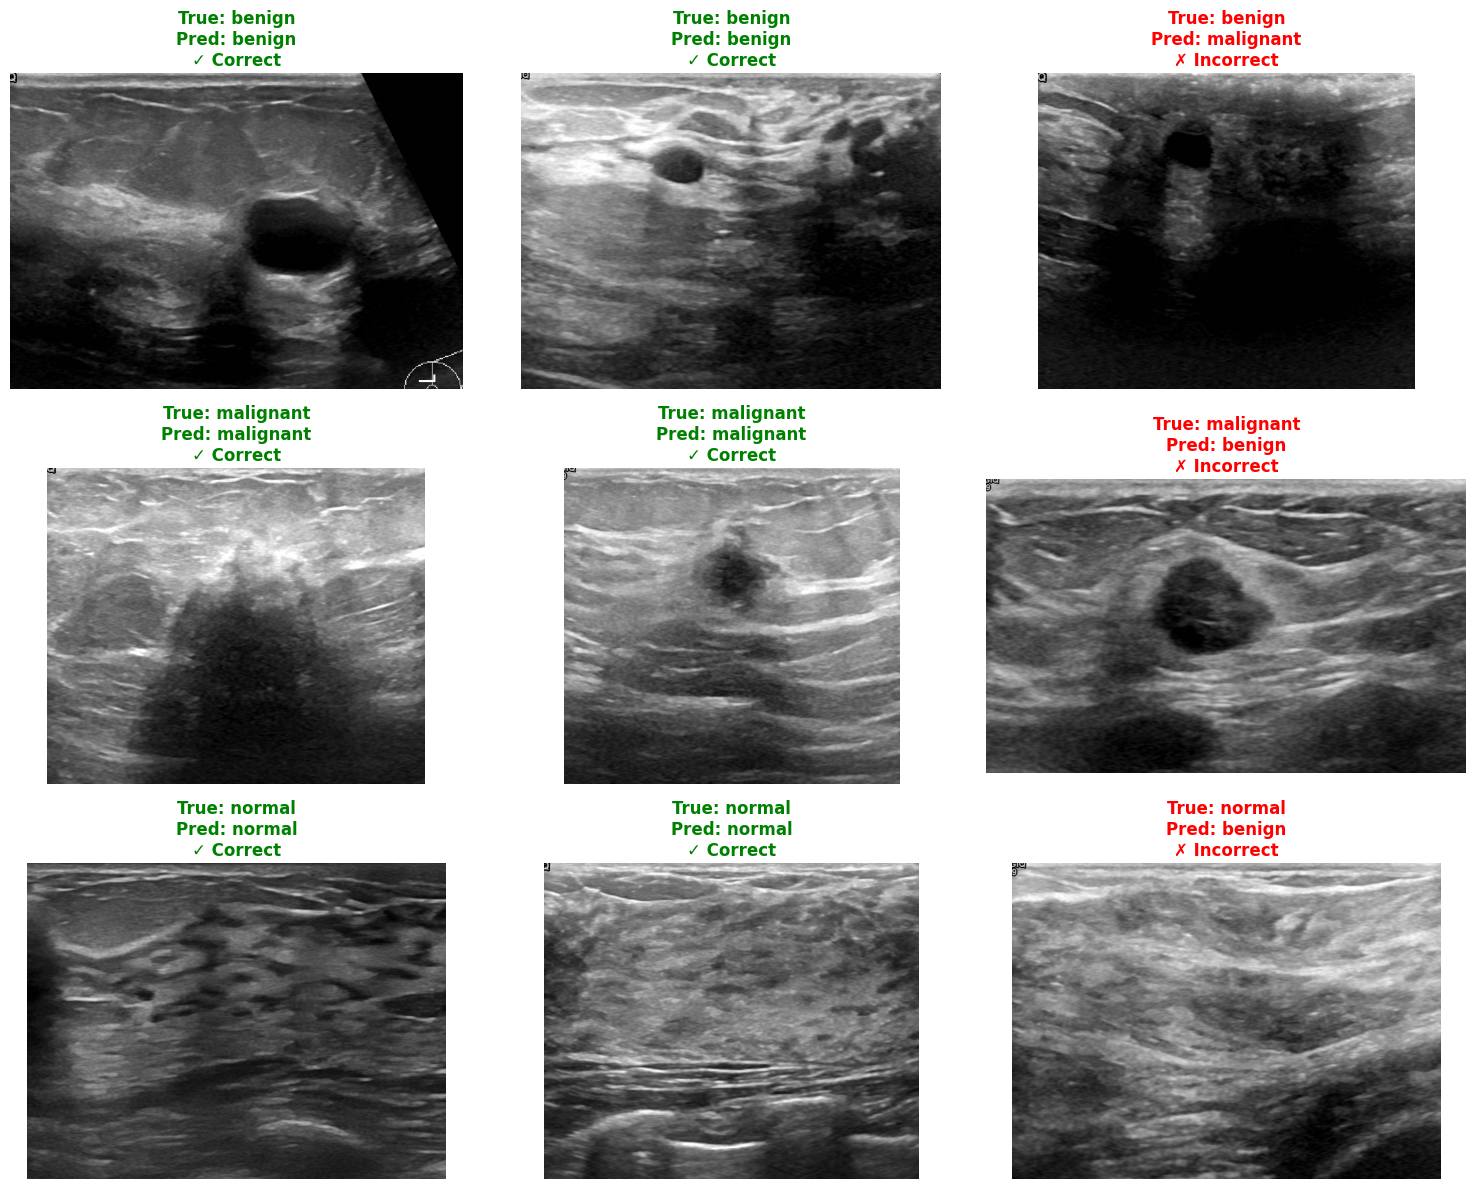

In [ ]:

# display sample predictions with true and predicted classes
from PIL import Image

class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


test_images = []
test_labels_true = []
test_predictions = []

for class_name, image_paths in test_image_paths.items():
    for img_path in image_paths:
        test_images.append(img_path)
        test_labels_true.append(class_indices.get(class_name, 0))

# get prediction
test_images_array = []
for img_path in test_images:
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    test_images_array.append(img_array)

test_images_array = np.array(test_images_array)
predictions = model.predict(test_images_array)
predicted_classes = np.argmax(predictions, axis=1)

# organize predictions by true class with correct/incorrect split
predictions_by_true_class = {class_name: {'correct': [], 'incorrect': []} for class_name in class_names.values()}

for img_path, true_class_idx, pred_class_idx in zip(test_images, test_labels_true, predicted_classes):
    true_class_name = class_names[true_class_idx]
    pred_class_name = class_names[pred_class_idx]
    
    result = {
        'img_path': img_path,
        'true_class': true_class_name,
        'pred_class': pred_class_name
    }
    
    if true_class_idx == pred_class_idx:
        predictions_by_true_class[true_class_name]['correct'].append(result)
    else:
        predictions_by_true_class[true_class_name]['incorrect'].append(result)

# display 2 correctly predicted and 1 incorrectly predicted for each category
num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, 3, figsize=(15, 4 * num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

for row, true_class in enumerate(sorted(predictions_by_true_class.keys())):
    correct_preds = predictions_by_true_class[true_class]['correct']
    incorrect_preds = predictions_by_true_class[true_class]['incorrect']
    
    # correctly predicted
    for col in range(2):
        if col < len(correct_preds):
            img_data = correct_preds[col]
            img = Image.open(img_data['img_path']).convert('RGB')
            axes[row, col].imshow(img)
            title = f"True: {img_data['true_class']}\nPred: {img_data['pred_class']}\n✓ Correct"
            axes[row, col].set_title(title, fontweight='bold', color='green')
        else:
            axes[row, col].text(0.5, 0.5, f"No correct predictions", 
                              ha='center', va='center', fontsize=12)
        axes[row, col].axis('off')
    
    # incorrectly predicted
    if len(incorrect_preds) > 0:
        img_data = incorrect_preds[0]
        img = Image.open(img_data['img_path']).convert('RGB')
        axes[row, 2].imshow(img)
        title = f"True: {img_data['true_class']}\nPred: {img_data['pred_class']}\n✗ Incorrect"
        axes[row, 2].set_title(title, fontweight='bold', color='red')
    else:
        axes[row, 2].text(0.5, 0.5, f"No incorrect predictions", 
                          ha='center', va='center', fontsize=12)
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()
